## Import Libraries

In [143]:
!pip install scikit-optimize

In [144]:
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from skopt import BayesSearchCV
from tqdm import tqdm
import hashlib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import Data

In [145]:
# Load training and testing data from pickle files
X_train = pd.read_pickle('/content/Processed/X_train_ohe.pkl')
X_test = pd.read_pickle('/content/Processed/X_test_ohe.pkl')
y_train = pd.read_pickle('/content/Processed/y_train.pkl')
y_test = pd.read_pickle('/content/Processed/y_test.pkl')

In [146]:
X_train.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:WESTERN AND CENTRAL AFRICA,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_a,loan_type:group_b,loan_type:group_c,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:40215236.00_to_54947816.00,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor,country_guarantor_status:same
5192,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1
774,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1529,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
3182,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4057,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [147]:
X_test.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:WESTERN AND CENTRAL AFRICA,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_a,loan_type:group_b,loan_type:group_c,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:40215236.00_to_54947816.00,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor,country_guarantor_status:same
4569,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
5011,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3787,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4270,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2424,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [148]:
y_train.head()

5192    0
774     0
1529    0
3182    0
4057    0
Name: bad, dtype: int64

In [149]:
y_test.head()

4569    0
5011    0
3787    0
4270    0
2424    0
Name: bad, dtype: int64

# Models Training and Evaluation

In [150]:
X_train.shape, X_test.shape

((3887, 39), (1666, 39))

In [151]:
y_train.shape, y_test.shape

((3887,), (1666,))

In [152]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3887 entries, 5192 to 2991
Data columns (total 39 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC  3887 non-null   int64
 1   region:EUROPE AND CENTRAL ASIA & SOUTH ASIA                 3887 non-null   int64
 2   region:LATIN AMERICA AND CARIBBEAN                          3887 non-null   int64
 3   region:MIDDLE EAST AND NORTH AFRICA                         3887 non-null   int64
 4   region:WESTERN AND CENTRAL AFRICA                           3887 non-null   int64
 5   country:group_a                                             3887 non-null   int64
 6   country:group_b                                             3887 non-null   int64
 7   country:group_c                                             3887 non-null   int64
 8   country:group_d

In [153]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 4569 to 3538
Data columns (total 39 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC  1666 non-null   int64
 1   region:EUROPE AND CENTRAL ASIA & SOUTH ASIA                 1666 non-null   int64
 2   region:LATIN AMERICA AND CARIBBEAN                          1666 non-null   int64
 3   region:MIDDLE EAST AND NORTH AFRICA                         1666 non-null   int64
 4   region:WESTERN AND CENTRAL AFRICA                           1666 non-null   int64
 5   country:group_a                                             1666 non-null   int64
 6   country:group_b                                             1666 non-null   int64
 7   country:group_c                                             1666 non-null   int64
 8   country:group_d

In [154]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 3887 entries, 5192 to 2991
Series name: bad
Non-Null Count  Dtype
--------------  -----
3887 non-null   int64
dtypes: int64(1)
memory usage: 60.7 KB


In [155]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 1666 entries, 4569 to 3538
Series name: bad
Non-Null Count  Dtype
--------------  -----
1666 non-null   int64
dtypes: int64(1)
memory usage: 26.0 KB


## Training Log

In [156]:
# Function to get the current timestamp
def time_stamp():
    return datetime.now()

# Function to create an empty logger dictionary
def create_logger():
    return {
        "model_name": [],                 # List to store model names
        "model_uid": [],                  # List to store unique model identifiers
        "training_time": [],              # List to store training times
        "training_date": [],              # List to store training dates
        "performance": [],                # List to store performance metrics
        "f1_score_avg": [],               # List to store average F1 scores
        "data_configurations": []         # List to store data configurations
    }

# Function to update the training log with a new entry
def training_log_updater(current_log, log_path):
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
    except FileNotFoundError:
        with open(log_path, "w") as file:
            file.write("[]")
        with open(log_path, "r") as file:
            last_log = json.load(file)
    last_log.append(current_log)
    with open(log_path, "w") as file:
        json.dump(last_log, file)
    return last_log

# Function for model training and evaluation
def model_training_and_evaluation(models_list, model_prefix, X_train, y_train, X_test, y_test, data_configuration, log_path):
    logger = create_logger()
    for model in tqdm(models_list):
        model_name = model_prefix + "-" + model["model_name"]
        start_time = time_stamp()
        model["model_object"].fit(X_train, y_train)
        finished_time = time_stamp()
        elapsed_time = (finished_time - start_time).total_seconds()
        y_prediction = model["model_object"].predict(X_test)
        performance = classification_report(y_test, y_prediction, output_dict = True)
        original_id = str(start_time) + str(finished_time)
        hashed_id = hashlib.md5(original_id.encode()).hexdigest()
        model["model_uid"] = hashed_id
        logger["model_name"].append(model_name)
        logger["model_uid"].append(hashed_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration)
    training_log = training_log_updater(logger, log_path)
    return training_log, models_list

# Function to convert the training log into a DataFrame
def training_log_to_df_converter(training_log):
    all_training_logs_df = pd.DataFrame()
    for log in tqdm(training_log):
        individual_log_df = pd.DataFrame(log)
        performance_df = pd.json_normalize(individual_log_df["performance"])
        individual_log_df = pd.concat([individual_log_df.drop("performance", axis = 1), performance_df], axis = 1)
        all_training_logs_df = pd.concat([all_training_logs_df, individual_log_df])
    all_training_logs_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    all_training_logs_df.reset_index(inplace = True, drop = True)
    return all_training_logs_df

# Function to find the best model from the training log
def best_model_finder(all_training_logs_df, models_list):
    model_object = None
    best_model_info = all_training_logs_df.iloc[0]
    for configuration_data in models_list:
        for model_data in models_list[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    return model_object

# Function to find a tuned model from the list of models
def tuned_model_finder(models_list_tuned, tuning_method):
    for model in models_list_tuned:
        if tuning_method in model["model_name"]:
            return model["model_object"]
    print(f"No model found that was tuned with {tuning_method}")
    return None

## Baseline Models

In [157]:
X_train_ori = X_train.copy()
X_test_ori = X_test.copy()

In [158]:
original_feature_name = X_train.columns.tolist()
original_feature_name

['region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC',
 'region:EUROPE AND CENTRAL ASIA & SOUTH ASIA',
 'region:LATIN AMERICA AND CARIBBEAN',
 'region:MIDDLE EAST AND NORTH AFRICA',
 'region:WESTERN AND CENTRAL AFRICA',
 'country:group_a',
 'country:group_b',
 'country:group_c',
 'country:group_d',
 'country:group_e',
 'country:group_f',
 'country:group_g',
 'country:group_h',
 'country:group_i',
 'country:group_j',
 'country:group_k',
 'guarantor:group_a',
 'guarantor:group_b',
 'guarantor:group_c',
 'guarantor:group_d',
 'guarantor:group_e',
 'guarantor:group_f',
 'guarantor:group_g',
 'guarantor:group_h',
 'guarantor:group_i',
 'guarantor:group_j',
 'loan_type:group_a',
 'loan_type:group_b',
 'loan_type:group_c',
 'principal_amount:-inf_to_1978840.31',
 'principal_amount:1978840.31_to_8013587.75',
 'principal_amount:23240000.00_to_40215236.00',
 'principal_amount:249441952.00_to_inf',
 'principal_amount:40215236.00_to_54947816.00',
 'principal_amount:54947816.00_to_249441952

In [159]:
reference_categories = ["region:WESTERN AND CENTRAL AFRICA", "country:group_a", "guarantor:group_a", "loan_type:group_a", "principal_amount:40215236.00_to_54947816.00", "country_guarantor_status:same"]

In [160]:
# Remove columns corresponding to reference categories from the training data
X_train = X_train.drop(columns=reference_categories)

# Remove columns corresponding to reference categories from the testing data
X_test = X_test.drop(columns=reference_categories)
X_train.shape, X_test.shape

((3887, 33), (1666, 33))

In [161]:
X_train.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_b,loan_type:group_c,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor
5192,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
774,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1529,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3182,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4057,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [162]:
X_test.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_b,loan_type:group_c,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor
4569,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
5011,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3787,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4270,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2424,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0


In [163]:
log_reg_baseline = LogisticRegression(random_state = 777)

In [164]:
# Define a dictionary of models for different configurations
models_list = {
    "vanilla": [
        # Add a logistic regression model with default settings to the list of models
        {"model_name": log_reg_baseline.__class__.__name__, "model_object": log_reg_baseline, "model_uid": ""},
    ]
}


In [165]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(random_state=777),
   'model_uid': ''}]}

### Vanilla Models

In [166]:
# The results and logs from the training process will be saved to a JSON file located at '/content/training_log.json'.
training_log, models_list_vanilla = model_training_and_evaluation(
    models_list["vanilla"],
    "baseline_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "vanilla",
    '/content/training_log.json')


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 1/1 [00:00

In [167]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(random_state=777),
   'model_uid': '2630d5ea071925173ab2ebd4b092da31'}]}

## Models Selection

### Benchmark Performance Review

In [168]:
benchmark = y_train.value_counts(normalize = True)[0]
benchmark

0.9709287368150245

### Baseline Best Model Performance Review

In [169]:
all_training_logs_df = training_log_to_df_converter(training_log)
all_training_logs_df.shape

100%|██████████| 6/6 [00:00<00:00, 114.05it/s]


(6, 23)

In [170]:
all_training_logs_df

,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,tuned_model-BayesSearchCV-LogisticRegression,eed5cccfbe9b8c1258a37b21bfc09e2a,62.460627,2023-07-04 03:06:23.210097,0.583787,tuned,0.953892,0.960341,0.992735,0.976269,1927,0.440000,0.122222,0.191304,90,0.700171,0.557479,0.583787,2017,0.937123,0.953892,0.941244,2017
1,baseline_model-LogisticRegression,30be66352cd3bfa72d5618ced7f79f48,0.038078,2023-07-04 03:06:18.126285,0.556641,vanilla,0.955875,0.958583,0.996886,0.977359,1927,0.538462,0.077778,0.135922,90,0.748522,0.537332,0.556641,2017,0.939837,0.955875,0.939814,2017
2,tuned_model-BayesSearchCV-LogisticRegression,f278c5c5e47212d3a04155def10a8077,161.961342,2023-09-18 09:17:44.573203,0.552442,tuned,0.981393,0.981370,1.000000,0.990598,1633,1.000000,0.060606,0.114286,33,0.990685,0.530303,0.552442,1666,0.981739,0.981393,0.973240,1666
3,tuned_model-BayesSearchCV-LogisticRegression,2c965a7f72f68eb636e4a641eae79b00,188.649792,2023-09-18 10:00:51.878285,0.552442,tuned,0.981393,0.981370,1.000000,0.990598,1633,1.000000,0.060606,0.114286,33,0.990685,0.530303,0.552442,1666,0.981739,0.981393,0.973240,1666
4,baseline_model-LogisticRegression,2630d5ea071925173ab2ebd4b092da31,0.036974,2023-09-18 10:13:11.068934,0.494998,vanilla,0.980192,0.980192,1.000000,0.989997,1633,0.000000,0.000000,0.000000,33,0.490096,0.500000,0.494998,1666,0.960777,0.980192,0.970387,1666
5,baseline_model-LogisticRegression,340a2795bed0db10a61eef875aa504e2,0.063591,2023-09-18 09:58:24.144006,0.494998,vanilla,0.980192,0.980192,1.000000,0.989997,1633,0.000000,0.000000,0.000000,33,0.490096,0.500000,0.494998,1666,0.960777,0.980192,0.970387,1666


In [171]:
# baseline_best_model = best_model_finder(all_training_logs_df, models_list)
baseline_best_model

LogisticRegression(random_state=777)

In [172]:
baseline_train_prediction = baseline_best_model.predict(X_train)
baseline_test_prediction = baseline_best_model.predict(X_test)

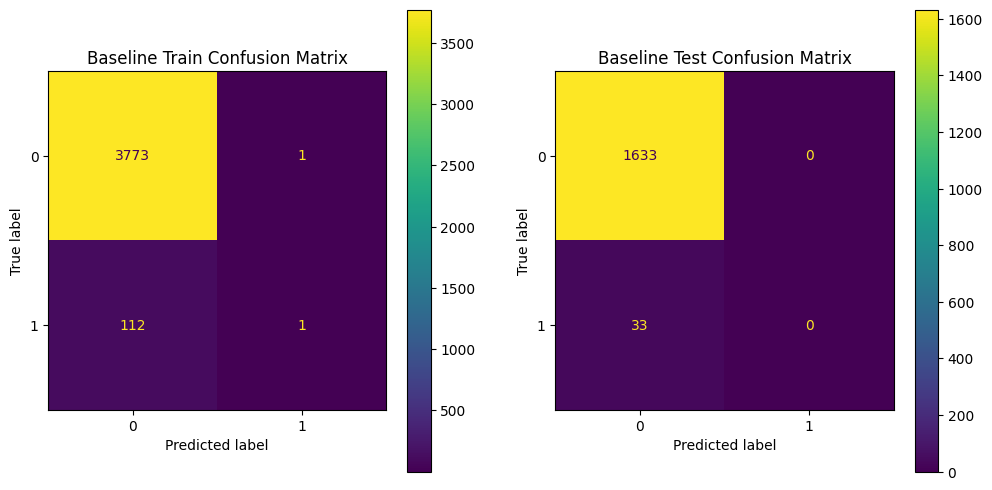

In [173]:
# Create a figure with two subplots arranged in a single row
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the confusion matrix for the baseline model's predictions on the training data
ConfusionMatrixDisplay.from_predictions(y_train, baseline_train_prediction, ax=ax[0])

# Set the title for the first subplot
ax[0].set_title("Baseline Train Confusion Matrix")

# Display the confusion matrix for the baseline model's predictions on the test data
ConfusionMatrixDisplay.from_predictions(y_test, baseline_test_prediction, ax=ax[1])

# Set the title for the second subplot
ax[1].set_title("Baseline Test Confusion Matrix")

# Show the figure with the two confusion matrices
plt.show()


In [174]:
# Function to calculate various classification metrics
def get_prediction_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict = True)
    accuracy = accuracy_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)

    # Create a dictionary to store various classification metrics.
    metrics = {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "accuracy": accuracy,
        "auc_roc": auc_roc
    }
    return metrics # Return the computed metrics.

In [175]:
# Calculate prediction metrics for the baseline model on the training data
baseline_train_metrics = get_prediction_metrics(y_train, baseline_train_prediction)

# Add a column to specify the dataset as "Train" for the training metrics
baseline_train_metrics["dataset"] = "Train"

# Calculate prediction metrics for the baseline model on the test data
baseline_test_metrics = get_prediction_metrics(y_test, baseline_test_prediction)

# Add a column to specify the dataset as "Test" for the test metrics
baseline_test_metrics["dataset"] = "Test"

# Create a DataFrame containing both training and test metrics
baseline_metrics_df = pd.DataFrame([baseline_train_metrics, baseline_test_metrics])

# Display the DataFrame with baseline metrics for both datasets
baseline_metrics_df


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,accuracy,auc_roc,dataset
0,0.957474,0.970929,0.957109,0.970929,0.504292,Train
1,0.960777,0.980192,0.970387,0.980192,0.500000,Test


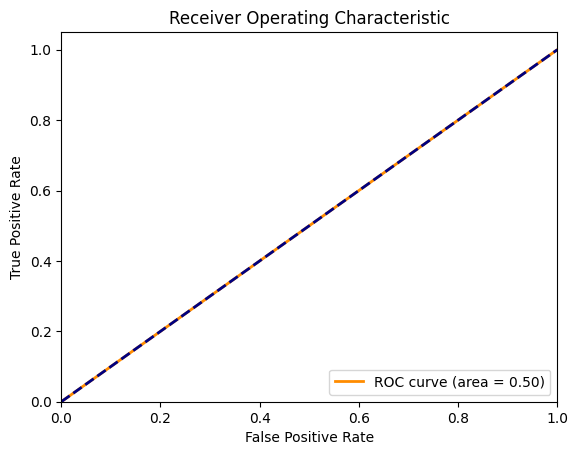

In [176]:
# Compute the ROC curve values using the actual labels (y_test) and predicted probabilities (baseline_test_prediction)
fpr, tpr, thresholds = roc_curve(y_test, baseline_test_prediction)

# Calculate the Area Under the ROC Curve (ROC AUC)
roc_auc = auc(fpr, tpr)

# Create a new figure for plotting
plt.figure()

# Plot the ROC curve with a label indicating the ROC AUC score
plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (area = %0.2f)" % roc_auc)

# Plot a diagonal dashed line representing random chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the x-axis and y-axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set labels for the x-axis and y-axis
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Set the title of the ROC curve plot
plt.title("Receiver Operating Characteristic")

# Display a legend in the lower right corner of the plot
plt.legend(loc='lower right')

# Show the ROC curve plot
plt.show()


### Baseline Best Model Bias-Variance Trade-Off Review

In [177]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [178]:
# Function to plot the learning curve of an estimator
def plot_learning_curve(estimator, title, X, y, cross_validation=None):
    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X,
                                                            y,
                                                            cv=cross_validation,
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(.1, 1.0, 5))

    # Calculate mean and standard deviation of training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation of test scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Create a grid for plotting
    plt.grid()

    # Set the title of the plot
    plt.title(title)

    # Set labels for the x-axis and y-axis
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    # Fill the area around the mean training scores with a red color
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")

    # Fill the area around the mean test scores with a green color
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")

    # Plot the mean training scores as red circles
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training Score")

    # Plot the mean test scores as green circles
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-Validation Score")

    # Display a legend in the best location
    plt.legend(loc="best")

    # Show the learning curve plot
    plt.show()


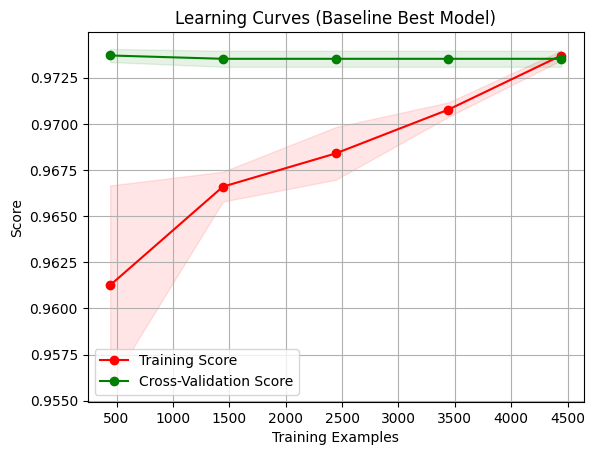

In [179]:
plot_learning_curve(baseline_best_model, "Learning Curves (Baseline Best Model)", X, y, cross_validation = 5)

### Export Baseline Best Model

In [180]:
# with open('../../models/baseline_best_model.pkl', 'wb') as file:
#     pickle.dump(baseline_best_model, file)

## IV.F. Hyperparameter Tuning

### IV.F.1. Bayesian Search Cross Validation

In [181]:
# Hyperparameter dictionary for logistic regression hyperparameter search
logistic_regression_hyperparams = {
    'penalty': ['l1', 'l2'],                # Regularization penalty: L1 or L2
    'C': (1e-5, 1e+5, 'log-uniform'),      # Inverse of regularization strength (log-uniform distribution)
    'fit_intercept': [True, False],         # Whether to fit an intercept term
    'class_weight': ['balanced', None],     # Weight of classes: 'balanced' or None
    'solver': ['liblinear', 'saga']         # Optimization solver: 'liblinear' or 'saga'
}


In [182]:
# Create a Bayesian search for hyperparameter tuning of a logistic regression model
logistic_regression_bayes_search = BayesSearchCV(
    estimator=baseline_best_model,            # The baseline logistic regression model
    search_spaces=logistic_regression_hyperparams,  # Hyperparameter search space
    n_iter=50,                                 # Number of iterations for optimization
    scoring='roc_auc',                         # Scoring metric to optimize
    n_jobs=-1,                                 # Number of CPU cores to use (-1 for all available)
    cv=5,                                      # Cross-validation folds
    verbose=420,                               # Verbosity level (higher for more output)
    random_state=777,                          # Random seed for reproducibility
    return_train_score=False                   # Do not return training scores
)


In [183]:
# Add a fine-tuned logistic regression model to the "fine-tuned" configuration in the models_list
models_list["fine-tuned"] = [
    {"model_name": logistic_regression_bayes_search.__class__.__name__ + "-" + logistic_regression_bayes_search.estimator.__class__.__name__, "model_object": logistic_regression_bayes_search, "model_uid": ""}
]

### Hyperparameter-tuned Model Retraining

In [184]:
# Perform model training and evaluation for fine-tuned models
training_log, models_list_tuned = model_training_and_evaluation(
    models_list["fine-tuned"],       # List of fine-tuned models
    "tuned_model",                   # Model prefix for naming
    X_train,                         # Training data features
    y_train,                         # Training data labels
    X_test,                          # Test data features
    y_test,                          # Test data labels
    "tuned",                         # Data configuration (e.g., fine-tuned)
    '/content/training_log.json'     # Path to the training log file
)


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


100%|██████████| 1/1 [03:02<00:00, 182.48s/it]


In [185]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(random_state=777),
   'model_uid': '2630d5ea071925173ab2ebd4b092da31'}],
 'fine-tuned': [{'model_name': 'BayesSearchCV-LogisticRegression',
   'model_object': BayesSearchCV(cv=5, estimator=LogisticRegression(random_state=777), n_jobs=-1,
                 random_state=777, scoring='roc_auc',
                 search_spaces={'C': (1e-05, 100000.0, 'log-uniform'),
                                'class_weight': ['balanced', None],
                                'fit_intercept': [True, False],
                                'penalty': ['l1', 'l2'],
                                'solver': ['liblinear', 'saga']},
                 verbose=420),
   'model_uid': '793177cfff85812b15b84c793e45e017'}]}

### Hyperparameter-tuned Model Performance Review

In [186]:
all_training_logs_df_tuned = training_log_to_df_converter(training_log)
all_training_logs_df_tuned.shape

100%|██████████| 7/7 [00:00<00:00, 144.50it/s]


(7, 23)

In [187]:
all_training_logs_df_tuned

,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,tuned_model-BayesSearchCV-LogisticRegression,eed5cccfbe9b8c1258a37b21bfc09e2a,62.460627,2023-07-04 03:06:23.210097,0.583787,tuned,0.953892,0.960341,0.992735,0.976269,1927,0.440000,0.122222,0.191304,90,0.700171,0.557479,0.583787,2017,0.937123,0.953892,0.941244,2017
1,baseline_model-LogisticRegression,30be66352cd3bfa72d5618ced7f79f48,0.038078,2023-07-04 03:06:18.126285,0.556641,vanilla,0.955875,0.958583,0.996886,0.977359,1927,0.538462,0.077778,0.135922,90,0.748522,0.537332,0.556641,2017,0.939837,0.955875,0.939814,2017
2,tuned_model-BayesSearchCV-LogisticRegression,f278c5c5e47212d3a04155def10a8077,161.961342,2023-09-18 09:17:44.573203,0.552442,tuned,0.981393,0.981370,1.000000,0.990598,1633,1.000000,0.060606,0.114286,33,0.990685,0.530303,0.552442,1666,0.981739,0.981393,0.973240,1666
3,tuned_model-BayesSearchCV-LogisticRegression,793177cfff85812b15b84c793e45e017,182.467281,2023-09-18 10:13:18.157104,0.552442,tuned,0.981393,0.981370,1.000000,0.990598,1633,1.000000,0.060606,0.114286,33,0.990685,0.530303,0.552442,1666,0.981739,0.981393,0.973240,1666
4,tuned_model-BayesSearchCV-LogisticRegression,2c965a7f72f68eb636e4a641eae79b00,188.649792,2023-09-18 10:00:51.878285,0.552442,tuned,0.981393,0.981370,1.000000,0.990598,1633,1.000000,0.060606,0.114286,33,0.990685,0.530303,0.552442,1666,0.981739,0.981393,0.973240,1666
5,baseline_model-LogisticRegression,2630d5ea071925173ab2ebd4b092da31,0.036974,2023-09-18 10:13:11.068934,0.494998,vanilla,0.980192,0.980192,1.000000,0.989997,1633,0.000000,0.000000,0.000000,33,0.490096,0.500000,0.494998,1666,0.960777,0.980192,0.970387,1666
6,baseline_model-LogisticRegression,340a2795bed0db10a61eef875aa504e2,0.063591,2023-09-18 09:58:24.144006,0.494998,vanilla,0.980192,0.980192,1.000000,0.989997,1633,0.000000,0.000000,0.000000,33,0.490096,0.500000,0.494998,1666,0.960777,0.980192,0.970387,1666


In [188]:
models_dict_tuned = {"fine-tuned": models_list_tuned}
tuned_best_model = tuned_model_finder(models_dict_tuned["fine-tuned"], "BayesSearchCV")
tuned_best_model

BayesSearchCV(cv=5, estimator=LogisticRegression(random_state=777), n_jobs=-1,
              random_state=777, scoring='roc_auc',
              search_spaces={'C': (1e-05, 100000.0, 'log-uniform'),
                             'class_weight': ['balanced', None],
                             'fit_intercept': [True, False],
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga']},
              verbose=420)

In [189]:
tuned_train_prediction = tuned_best_model.predict(X_train)
tuned_test_prediction = tuned_best_model.predict(X_test)

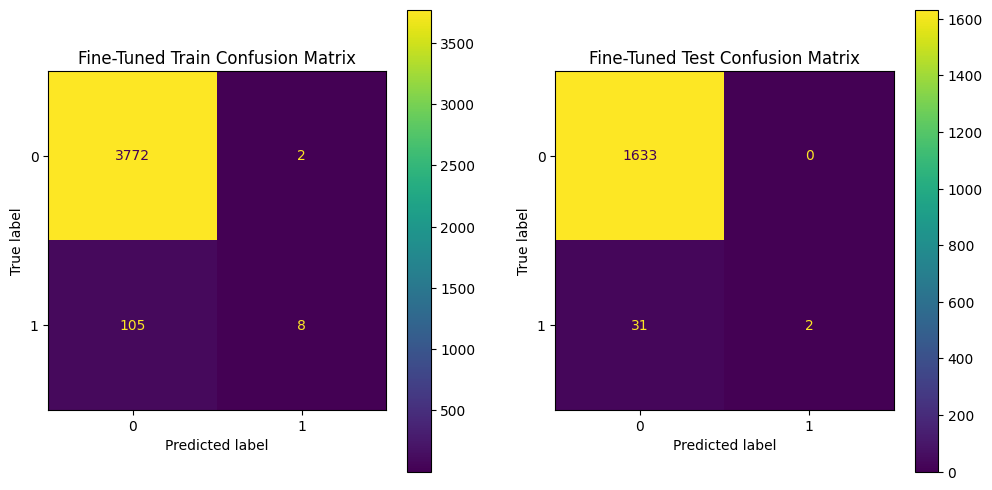

In [190]:
# Create a figure with two subplots arranged in a single row
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the confusion matrix for fine-tuned model's predictions on the training data
ConfusionMatrixDisplay.from_predictions(y_train, tuned_train_prediction, ax=ax[0])

# Set the title for the first subplot
ax[0].set_title("Fine-Tuned Train Confusion Matrix")

# Display the confusion matrix for fine-tuned model's predictions on the test data
ConfusionMatrixDisplay.from_predictions(y_test, tuned_test_prediction, ax=ax[1])

# Set the title for the second subplot
ax[1].set_title("Fine-Tuned Test Confusion Matrix")

# Show the figure with the two confusion matrices
plt.show()


In [191]:
# Calculate prediction metrics for the fine-tuned model on the training data
tuned_train_metrics = get_prediction_metrics(y_train, tuned_train_prediction)

# Add a column to specify the dataset as "Train" for the training metrics
tuned_train_metrics["dataset"] = "Train"

# Calculate prediction metrics for the fine-tuned model on the test data
tuned_test_metrics = get_prediction_metrics(y_test, tuned_test_prediction)

# Add a column to specify the dataset as "Test" for the test metrics
tuned_test_metrics["dataset"] = "Test"

# Create a DataFrame containing both training and test metrics for the fine-tuned model
tuned_metrics_df = pd.DataFrame([tuned_train_metrics, tuned_test_metrics])

# Display the DataFrame with metrics for both datasets
tuned_metrics_df


,precision,recall,f1-score,accuracy,auc_roc,dataset
0,0.967890,0.972472,0.961132,0.972472,0.535133,Train
1,0.981739,0.981393,0.973240,0.981393,0.530303,Test


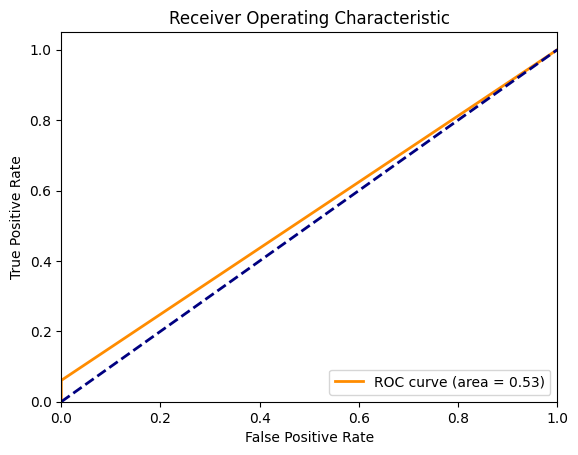

In [192]:
# Compute the ROC curve values using the actual labels (y_test) and predicted probabilities (tuned_test_prediction)
fpr, tpr, thresholds = roc_curve(y_test, tuned_test_prediction)

# Calculate the Area Under the ROC Curve (ROC AUC)
roc_auc = auc(fpr, tpr)

# Create a new figure for plotting
plt.figure()

# Plot the ROC curve with a label indicating the ROC AUC score
plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (area = %0.2f)" % roc_auc)

# Plot a diagonal dashed line representing random chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the x-axis and y-axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set labels for the x-axis and y-axis
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Set the title of the ROC curve plot
plt.title("Receiver Operating Characteristic")

# Display a legend in the lower right corner of the plot
plt.legend(loc='lower right')

# Show the ROC curve plot
plt.show()


### Export Hyperparameter-tuned Best Model

In [193]:
with open('/content/Processed/tuned_best_model.pkl', 'wb') as file:
    pickle.dump(tuned_best_model, file)

In [194]:
print(tuned_best_model)

BayesSearchCV(cv=5, estimator=LogisticRegression(random_state=777), n_jobs=-1,
              random_state=777, scoring='roc_auc',
              search_spaces={'C': (1e-05, 100000.0, 'log-uniform'),
                             'class_weight': ['balanced', None],
                             'fit_intercept': [True, False],
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga']},
              verbose=420)


## Probability-based Model Performance Review

In [195]:
# Calculate probability-based metrics for a classification model
def get_probability_metrics(model, X_test, y_test, prediction_threshold):
    # Predict probabilities using the model
    y_test_proba = model.predict_proba(X_test)
    y_test_proba = y_test_proba[:, 1]

    # Create a DataFrame combining true labels, predicted probabilities, and binary predictions
    y_test_copy = y_test.copy().reset_index(drop=True)
    y_test_proba_df = pd.concat([y_test_copy, pd.DataFrame(y_test_proba, columns=["y_test_proba"])], axis=1)
    y_test_proba_df.columns = ["y_test_true", "y_test_proba"]
    y_test_proba_df.index = X_test.index
    y_test_proba_df["y_test_pred"] = np.where(y_test_proba_df["y_test_proba"] >= prediction_threshold, 1, 0)

    # Calculate precision and recall values and thresholds for the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])

    # Calculate Area Under the ROC Curve (AUROC) using roc_auc_score
    AUROC = roc_auc_score(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])

    # Define and calculate various probability-based metrics
    metrics = {
        "average_precision": np.mean(precision),
        "average_recall": np.mean(recall),
        "auroc": AUROC,
        "gini": AUROC * 2 - 1,
        "auc_precision_recall": auc(recall, precision)
    }

    # Create a DataFrame to store the calculated metrics with appropriate column names
    proba_metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])

    # Return both the DataFrame containing true labels, predicted probabilities, and binary predictions
    return y_test_proba_df, proba_metrics_df


In [196]:
y_test_proba_df, proba_metrics_df = get_probability_metrics(tuned_best_model, X_test, y_test, prediction_threshold = 0.5)
y_test_proba_df.shape

(1666, 3)

In [197]:
y_test_proba_df.head()

,y_test_true,y_test_proba,y_test_pred
4569,0,0.151604,0
5011,0,0.025535,0
3787,0,0.057606,0
4270,0,0.034172,0
2424,0,0.087904,0


In [198]:
proba_metrics_df

,Value
average_precision,0.064901
average_recall,0.683061
auroc,0.749337
gini,0.498673
auc_precision_recall,0.197217


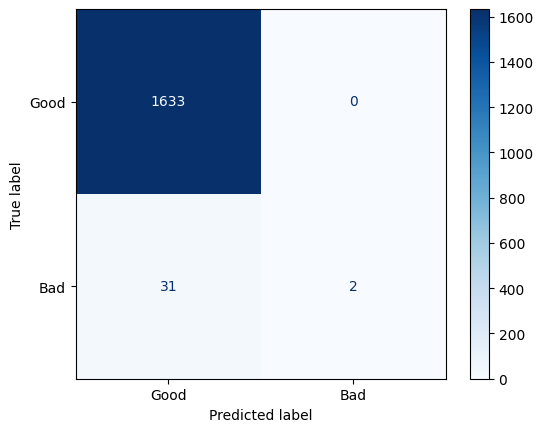

In [199]:
# Create a confusion matrix using true labels and predicted labels
cm = confusion_matrix(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_pred"])

# Create a ConfusionMatrixDisplay object with labels "Good" and "Bad"
cmd = ConfusionMatrixDisplay(cm, display_labels=["Good", "Bad"])

# Plot the confusion matrix using a blue color map (cmap)
cmd.plot(cmap='Blues')

# Display the plot
plt.show()


Text(0.5, 1.0, 'ROC Curve')

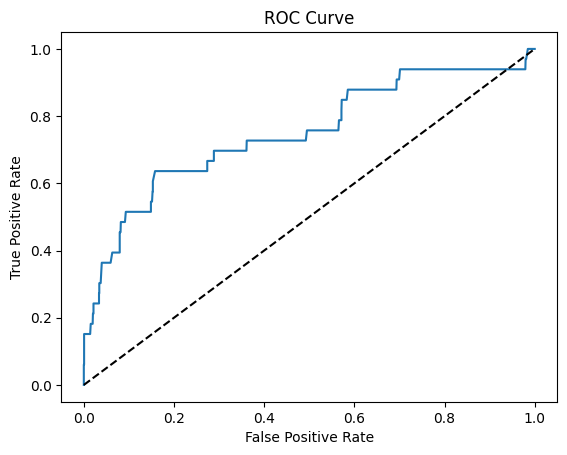

In [200]:
# Calculate the False Positive Rate (fpr), True Positive Rate (tpr), and thresholds for the ROC curve
fpr, tpr, threshold = roc_curve(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])

# Plot the ROC curve
plt.plot(fpr, tpr)

# Plot a diagonal line with a dashed linestyle (baseline for random classification)
plt.plot(fpr, fpr, linestyle='--', color='k')

# Set labels for the x-axis and y-axis
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Set the title for the ROC curve plot
plt.title("ROC Curve")

# Display the ROC curve plot


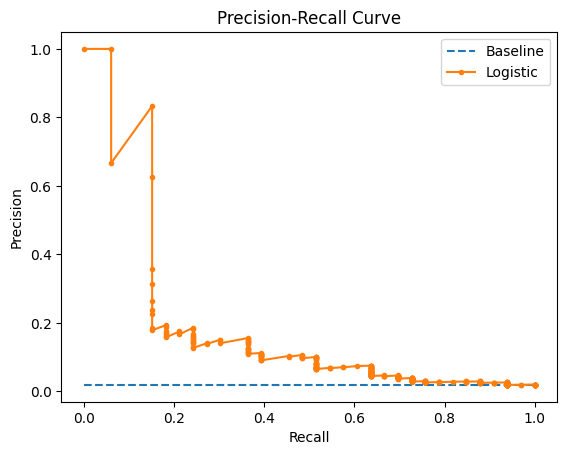

In [201]:
# Calculate the baseline precision as the proportion of positive samples in the test set
baseline = len(y_test[y_test == 1]) / len(y_test)

# Calculate precision and recall values and thresholds for the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])

# Set the title for the Precision-Recall Curve plot
plt.title("Precision-Recall Curve")

# Plot a dashed line representing the baseline precision
plt.plot([0, 1], [baseline, baseline], linestyle='--', label="Baseline")

# Plot the Precision-Recall curve using recall as x-axis and precision as y-axis
plt.plot(recall, precision, marker='.', label="Logistic")

# Set labels for the x-axis and y-axis
plt.xlabel("Recall")
plt.ylabel("Precision")

# Add a legend to the plot
plt.legend()

# Display the Precision-Recall Curve plot


# Scorecard Creation

## I. Scorecard Table Creation

In [202]:
def create_scorecard_first_iteration(model, X_train, reference_categories, min_score=0, max_score=1000):
    # Extract the names of the features from the training data
    feature_name = X_train.columns.tolist()

    # Create an empty DataFrame called summary_table to store feature coefficients
    summary_table = pd.DataFrame(columns=["Feature Name"], data=feature_name)

    # Add the intercept term to the summary table
    summary_table["Coefficients"] = np.transpose(model.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ["Intercept", model.intercept_[0]]

    # Sort the summary table by index
    summary_table.sort_index(inplace=True)

    # Create a DataFrame to store reference category coefficients
    reference_categories_df = pd.DataFrame(reference_categories, columns=["Feature Name"])
    reference_categories_df["Coefficients"] = 0

    # Concatenate the summary table with the reference categories table
    scorecard_df = pd.concat([summary_table, reference_categories_df])
    scorecard_df.reset_index(drop=True, inplace=True)

    # Extract the original feature names from the "Feature Name" column
    scorecard_df["Original Feature"] = scorecard_df["Feature Name"].str.split(":").str[0]

    # Calculate the score for each feature based on coefficients
    min_sum_coef = scorecard_df.groupby("Original Feature")["Coefficients"].min().sum()
    max_sum_coef = scorecard_df.groupby("Original Feature")["Coefficients"].max().sum()
    scorecard_df["Score - Calculation"] = (
        scorecard_df["Coefficients"] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
    )

    # Calculate the score for the intercept
    scorecard_df.loc[0, "Score - Calculation"] = (
        ((scorecard_df.loc[0, "Coefficients"] - min_sum_coef) / (max_sum_coef - min_sum_coef))
        * (max_score - min_score)
        + min_score
    )

    # Round the preliminary scores
    scorecard_df["Score - Preliminary"] = scorecard_df["Score - Calculation"].round()

    # Calculate the difference between preliminary scores and calculated scores
    scorecard_df["Difference"] = scorecard_df["Score - Preliminary"] - scorecard_df["Score - Calculation"]

    # Calculate the sum of preliminary scores for each original feature
    min_sum_score_preliminary = scorecard_df.groupby("Original Feature")["Score - Preliminary"].min().sum()
    max_sum_score_preliminary = scorecard_df.groupby("Original Feature")["Score - Preliminary"].max().sum()

    # Find the index with the maximum difference
    max_difference_idx = scorecard_df["Difference"].idxmax()

    return (
        scorecard_df,
        min_sum_score_preliminary,
        max_sum_score_preliminary,
        max_difference_idx
    )


In [203]:
scorecard_first_iteration, min_score, max_score, max_difference_idx = create_scorecard_first_iteration(tuned_best_model.best_estimator_, X_train, reference_categories, min_score = 300, max_score = 850)
scorecard_first_iteration

,Feature Name,Coefficients,Original Feature,Score - Calculation,Score - Preliminary,Difference
0,Intercept,-5.800058,Intercept,545.910033,546.0,0.089967
1,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA...,-0.125077,region,-2.322655,-2.0,0.322655
2,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,-0.330497,region,-6.137238,-6.0,0.137238
3,region:LATIN AMERICA AND CARIBBEAN,-0.788437,region,-14.641068,-15.0,-0.358932
4,region:MIDDLE EAST AND NORTH AFRICA,-0.249687,region,-4.636618,-5.0,-0.363382
5,country:group_b,0.373429,country,6.934475,7.0,0.065525
6,country:group_c,0.337071,country,6.259323,6.0,-0.259323
7,country:group_d,0.438982,country,8.151786,8.0,-0.151786
8,country:group_e,0.588529,country,10.928826,11.0,0.071174
9,country:group_f,6.166961,country,114.518859,115.0,0.481141


In [204]:
print("Scorecard First Iteration Minimum Score: ", min_score)
print("Scorecard First Iteration Maximum Score: ", max_score)
print("The Maximum Difference Location: ", max_difference_idx)

Scorecard First Iteration Minimum Score:  299.0
Scorecard First Iteration Maximum Score:  850.0
The Maximum Difference Location:  9


In [205]:
def create_final_scorecard(scorecard_df, original_feature_name, max_difference_idx):
    # Create a "Score - Final" column in the scorecard_df and initialize it with "Score - Preliminary"
    scorecard_df["Score - Final"] = scorecard_df["Score - Preliminary"]

    # Calculate the minimum and maximum sums of final scores for each original feature
    min_sum_score_final = scorecard_df.groupby("Original Feature")["Score - Final"].min().sum()
    max_sum_score_final = scorecard_df.groupby("Original Feature")["Score - Final"].max().sum()

    # Drop unnecessary columns from the scorecard_df
    scorecard_df.drop(["Score - Calculation", "Score - Preliminary", "Difference"], axis=1, inplace=True)

    # Extract the row corresponding to the intercept and store it separately
    intercept_row = scorecard_df[scorecard_df["Feature Name"] == "Intercept"]

    # Remove the intercept row from the scorecard_df
    scorecard_df = scorecard_df[scorecard_df["Feature Name"] != "Intercept"]

    # Set the index of the scorecard_df to "Feature Name" for easier manipulation
    scorecard_df.set_index("Feature Name", inplace=True)

    # Filter the rows of scorecard_df based on the original feature names
    scorecard_df = scorecard_df.loc[original_feature_name]

    # Reset the index of scorecard_df
    scorecard_df.reset_index(inplace=True)

    # Concatenate the intercept row and the filtered scorecard_df to create the final scorecard
    scorecard_df = pd.concat([intercept_row, scorecard_df], ignore_index=True)

    return scorecard_df, min_sum_score_final, max_sum_score_final


In [206]:
final_scorecard, min_score_final, max_score_final = create_final_scorecard(scorecard_first_iteration, original_feature_name, max_difference_idx)
final_scorecard

,Feature Name,Coefficients,Original Feature,Score - Final
0,Intercept,-5.800058,Intercept,546.0
1,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA...,-0.125077,region,-2.0
2,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,-0.330497,region,-6.0
3,region:LATIN AMERICA AND CARIBBEAN,-0.788437,region,-15.0
4,region:MIDDLE EAST AND NORTH AFRICA,-0.249687,region,-5.0
5,region:WESTERN AND CENTRAL AFRICA,0.000000,region,0.0
6,country:group_a,0.000000,country,0.0
7,country:group_b,0.373429,country,7.0
8,country:group_c,0.337071,country,6.0
9,country:group_d,0.438982,country,8.0


In [207]:
print("Final Scorecard Minimum Score: ", min_score_final)
print("Final Scorecard Maximum Score: ", max_score_final)

Final Scorecard Minimum Score:  299.0
Final Scorecard Maximum Score:  850.0


## Train - Test Scorecard Implementation Review

In [208]:
def get_score(df, scorecard):
    # Create a copy of the input DataFrame
    df_copy = df.copy()

    # Find the missing columns in the DataFrame that are present in the scorecard
    missing_cols = set(scorecard["Feature Name"]) - set(df.columns)

    # Add missing columns to the DataFrame and set their values to 0
    for column in missing_cols:
        df_copy[column] = 0

    # Add an "Intercept" column with all values set to 1
    df_copy["Intercept"] = 1

    # Reorder the columns of the DataFrame to match the order in the scorecard
    df_copy = df_copy[scorecard["Feature Name"]]

    # Extract the "Score - Final" values from the scorecard and reshape them
    scorecard_scores = scorecard["Score - Final"].values.reshape(scorecard.shape[0], 1)

    # Calculate the scores for the DataFrame by multiplying it with the reshaped scorecard scores
    df_scored = df_copy.dot(scorecard_scores)

    return df_scored


In [209]:
X_train_scored = get_score(X_train, final_scorecard)
X_train_scored.head()

,0
5192,586.0
774,546.0
1529,559.0
3182,561.0
4057,579.0


In [210]:
print("X_train Minimum Score: ", X_train_scored.min())
print("X_train Maximum Score: ", X_train_scored.max())

X_train Minimum Score:  0    321.0
dtype: float64
X_train Maximum Score:  0    693.0
dtype: float64


In [211]:
X_test_scored = get_score(X_test, final_scorecard)
X_test_scored.head()

,0
4569,621.0
5011,586.0
3787,602.0
4270,592.0
2424,610.0


In [212]:
print("X_test Minimum Score: ", X_test_scored.min())
print("X_test Maximum Score: ", X_test_scored.max())

X_test Minimum Score:  0    421.0
dtype: float64
X_test Maximum Score:  0    655.0
dtype: float64


## Export Final Scorecard Model

In [213]:
with open('/content/Processed/final_scorecard.pkl', 'wb') as file:
    pickle.dump(final_scorecard, file)

## Export Final Scorecard Summary

In [214]:
final_scorecard.to_csv('/content/Processed/final_scorecard.csv', index = False)